
### Environment setup



In [1]:
begin
	# Environment setup
	import Pkg
	Pkg.activate(".")
	using OrdinaryDiffEq, Optimization, OptimizationPolyalgorithms, SciMLSensitivity, ModelingToolkit, Optim, ForwardDiff, Plots, DelimitedFiles
end

  Activating project at `~/Documents/Master/MasterThesis/RhoAModelling/Code`



## Data fitting of RhoA activation/deactivation dynamics at Focal Adhesions
This notebook contains the code used to fit an ODE model to the experimental data of RhoA activity obtained after local light stimulation at focal adhesions as described in the paper by Heydasch et al. \


Max Heydasch, Lucien Hinderling, Jakobus van Unen, Maciej Dobrzynski, Olivier Pertz
(2023) \
**GTPase activating protein DLC1 spatio-temporally regulates Rho signaling** \
eLife 12:RP90305 \
https://doi.org/10.7554/eLife.90305.1  

Data source: Lucien Hinderling, Pertz Lab, Institute of Cell Biology, University of Bern, Switzerland.




### Initial steps
##### - Light signal function
To use the gradient for parameter optimisation, the ODE system needs to be composed of continuous and differentiable function to avoid instability with the ODE solver. Instead of a step function, the light signal is modelled using a hyperbolic tangent.



In [2]:
# Define symbolic functions and variables for ODE model
begin
	@independent_variables t
	D = Differential(t)
	
	# Light signal function (step function)
	f(t) = (160 <= t <= 160.8)
	@register_symbolic f(t) 
	
    # Use hyperbolic tangent as continuous approximation of light signal function to have continuous derivatives for optimisation 
	f_tanh(t) = (tanh(100*(t-160))/2 - tanh(100*(t-160.8))/2)
	@register_symbolic f_tanh(t)
end

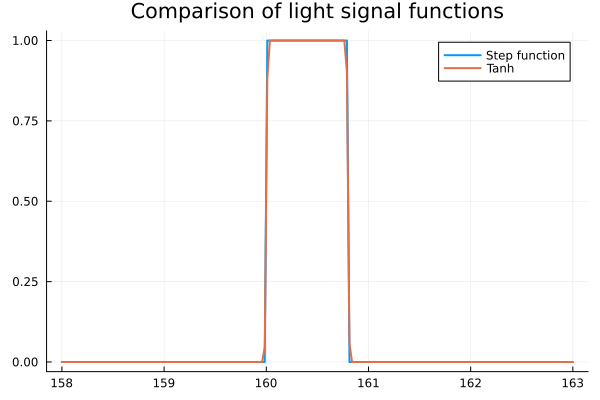

In [3]:
# Check the light signal functions 
begin
	x = LinRange(158, 163, 200)
	y1 = f.(x)
	y2 = f_tanh.(x)
	plot(x, [y1, y2], labels =["Step function" "Tanh"], lw = 2, title="Comparison of light signal functions")
end


##### - Import RhoA data



In [4]:
# Import data saved in txt files (Python preprocessing pickle file)
begin
	path_to_data = "../Data/"
	median_rhoa_FA = readdlm(Base.Filesystem.joinpath(path_to_data, "median_rhoa_FA_dynamics.txt"), ' ', Float64, '\n')[:, 2]
	median_rhoa_FA_KO = readdlm(Base.Filesystem.joinpath(path_to_data, "median_rhoa_FA_KO_dynamics.txt"), ' ', Float64, '\n')[:, 2]
	timeframe = LinRange(10, 400, 40)
end

40-element LinRange{Float64, Int64}:
 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, …, 360.0, 370.0, 380.0, 390.0, 400.0

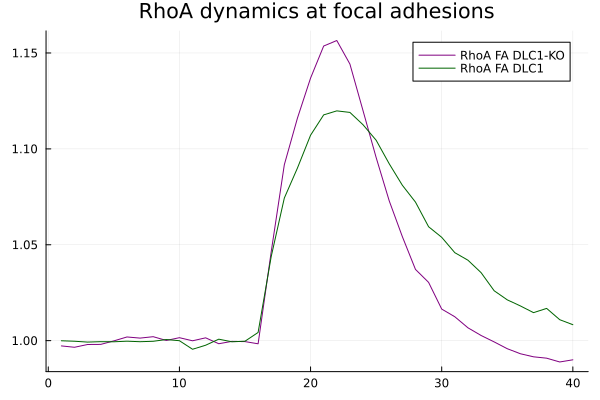

In [5]:
# Visualise data
begin
	plot(median_rhoa_FA_KO, label = "RhoA FA DLC1-KO", color="#800080")
	plot!(median_rhoa_FA, label = "RhoA FA DLC1", title= "RhoA dynamics at focal adhesions", color="#006400")
end


### RhoA data fitting



In [6]:
# Custom function to retrieve the index of the parameter in the optimisation solution 
# array using its symbolic expression (symbol)
function get_idxparam(symbol, prob)
	mtk_p = prob.ps
	mtk_p_array = prob.p.tunable
	for i in eachindex(mtk_p_array)
		if mtk_p[symbol] == mtk_p_array[i]
			return i
		end
	end
end

get_idxparam (generic function with 1 method)


#### 1: WT cells



In [7]:
# Define RhoA negative autoregulation model for RhoA dynamics in WT
@mtkmodel Rho_dynamics begin
	
	@parameters begin
		Kon_GAP	
		Koff_GAP
		Kon_Rho
		Koff_Rho
	end
	
	@variables begin
		GEF(t), [bounds = (0, 10)]
		GAP(t), [bounds = (0, 10)]
		Rho(t), [bounds = (0, 10)]
		S(t)
	end
	
	@equations begin
		D(GEF) ~ 0.034 * (0.2 * S - GEF)
		D(GAP) ~ Kon_GAP * (1 - GAP) * (Rho-1) - Koff_GAP * GAP
		D(Rho) ~ Kon_Rho * GEF * (2 - Rho) - Koff_Rho * GAP * Rho
		S ~ f_tanh(t)
	end
end
@mtkbuild Rho_model = Rho_dynamics()

Model Rho_model:
Equations (3):
  3 standard: see equations(Rho_model)
Unknowns (3): see unknowns(Rho_model)
  GEF(t)
  GAP(t)
  Rho(t)
Parameters (4): see parameters(Rho_model)
  Koff_GAP
  Kon_GAP
  Koff_Rho
  Kon_Rho
Observed (1): see observed(Rho_model)

In [8]:
begin
	# Define some initial parameters for the ODE model
	parameter_guess = [0.1, 0.12, 0.13, 0.14] 
	
    # Build ODE problems with guess parameters and initial conditions
	Rho_prob = ODEProblem(Rho_model, 
		[Rho_model.GEF => 0, 
			Rho_model.Rho => 1,
			Rho_model.GAP => 0
		], 
		(150.0, 400.0), 
		parameter_guess, jac = true)
end

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (150.0, 400.0)
u0: 3-element Vector{Float64}:
 0.0
 0.0
 1.0

In [9]:
# Define MSE loss function to estimate parameters for WT RhoA data
function MSE_loss(new_parameters)
	
    # Substitute the initial conditions in the parameters
	new_u0 = [0; 0; 1]
	new_p = new_parameters[1:4]
	
	# Update the ODE problem with the new set of parameters
	new_ODE_prob = remake(Rho_prob, p = new_p, u0 = new_u0)
	
    # Solve the new ODE problem (saveat = numerical estimate time interval)
	new_sol = solve(new_ODE_prob, AutoVern9(Rodas4P()), saveat = 10, verbose = false, maxiters = 1e7, dtmax=0.05)
	new_sol_array = new_sol[Rho_model.Rho]
	
    # Determine the loss by computing the sum of squares
	if length(new_sol_array) == length(median_rhoa_FA[15:end])
		loss = sum(abs2, new_sol_array .- median_rhoa_FA[15:end])
	else
		loss = 1000
	end
	return loss
end

MSE_loss (generic function with 1 method)

In [10]:
# Define callback function that is run at each iteration
callback! = function(parameters, loss)
	
    # Add current loss value to tracking array
	push!(track_loss, loss)
	
	# Tell Optimization.solve to not halt the optimization. If return true, then
    # optimization stops.
	return false
end


#2 (generic function with 1 method)

In [11]:
begin
	# Define optimization function and differentiation method
	optimisation_f = Optimization.OptimizationFunction((x, p) -> MSE_loss(x), Optimization.AutoForwardDiff())
	
    # Keep track of loss values during iterations
	track_loss = []
	
    # Set upper and lower bound for the parameters and initial conditions
	lower_b = repeat([0.0001], 4)
	upper_b = repeat([5], 4)
	
    # Define the optimisation problem
	optimisation_prob = Optimization.OptimizationProblem(optimisation_f, parameter_guess, lb = lower_b, ub=upper_b)
end


OptimizationProblem. In-place: true
u0: 4-element Vector{Float64}:
 0.1
 0.12
 0.13
 0.14

In [12]:
begin 
	# Clear the tracking array if not empty
	if !isempty(track_loss)
		empty!(track_loss)
	end
	
	# Run the optimisation
	optim_results = Optimization.solve(optimisation_prob, LBFGS(), callback = callback!, maxiters = 100, progress = true)
end

retcode: Success
u: 4-element Vector{Float64}:
 0.1654412841747379
 4.99999999979779
 0.0012304133541551467
 1.2840215075701609

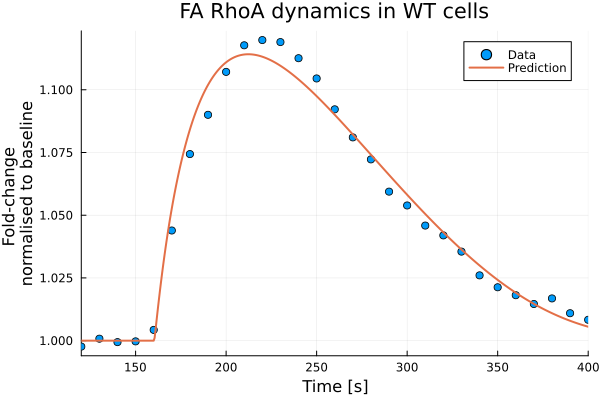

In [14]:
begin
	# Define initial conditions
	pred_u0 = [0; 0; 1]
	
    # Re-modify parameters as for optimisation
	pred_p = optim_results[1:4]
	
    # Solve the ODE problem with optimal parameters
	pred_sol = solve(remake(Rho_prob, p=pred_p, tspan=(120, 400)), u0=pred_u0, saveat=0.5, dtmax = 0.05)
	
    # Plot predicted model compared to data
	scatter(timeframe[12:end], median_rhoa_FA[12:end], label = "Data", lw=2, title = "FA RhoA dynamics in WT cells")
	plot!(pred_sol, label = "Prediction", lw=2, idxs=3, ylabel = "Fold-change \nnormalised to baseline", xlabel = "Time [s]")
end

In [15]:
# Visualise optimisation statistics
optim_results.original

 * Status: success

 * Candidate solution
    Final objective value:     7.880049e-04

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 5.13e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   45  (vs limit Inf)
    Iterations:    5
    f(x) calls:    1568
    ∇f(x) calls:   1568


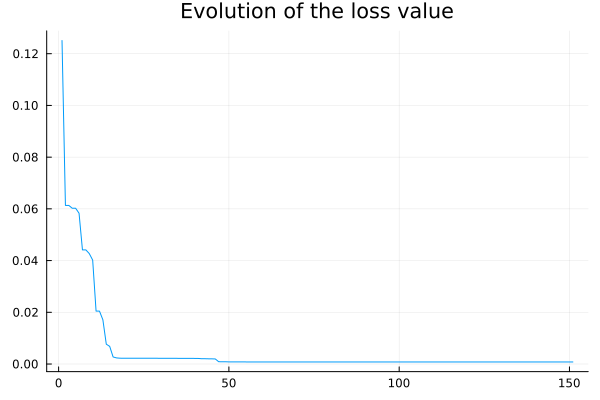

In [16]:
# Plot the loss value at each iteration
plot(track_loss, title = "Evolution of the loss value", label = false)

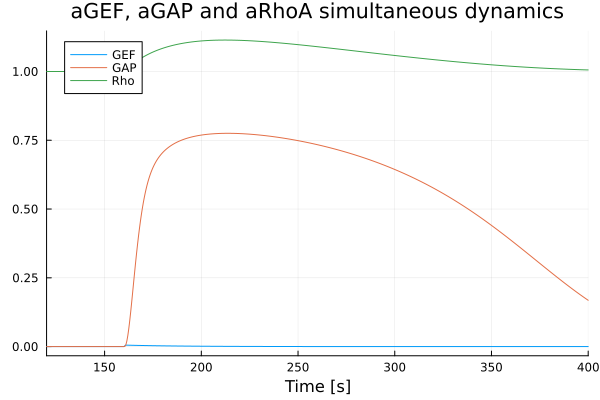

In [17]:
plot(pred_sol, title = "aGEF, aGAP and aRhoA simultaneous dynamics", xlabel = "Time [s]")

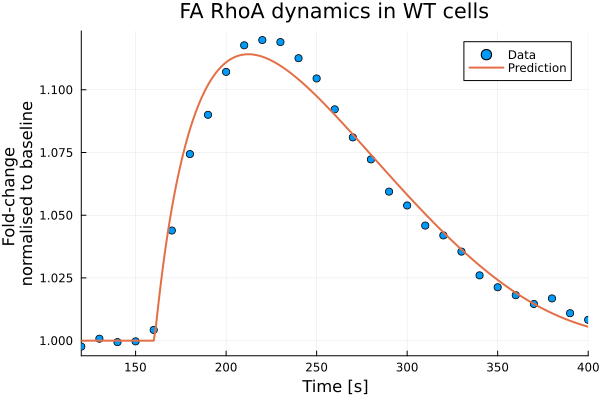

In [18]:
begin
	# Save best parameters
	saved_parameters = [0.165441, 5.0, 0.00123041, 1.28402]
	
    # Transform back ODE parameters to their symbolic expression
	saved_param = [
		Rho_model.Kon_GAP => saved_parameters[get_idxparam(Rho_model.Kon_GAP, Rho_prob)],
		Rho_model.Koff_GAP => saved_parameters[get_idxparam(Rho_model.Koff_GAP, Rho_prob)],
		Rho_model.Kon_Rho => saved_parameters[get_idxparam(Rho_model.Kon_Rho, Rho_prob)],
		Rho_model.Koff_Rho => saved_parameters[get_idxparam(Rho_model.Koff_Rho, Rho_prob)]]
	
	saved_u0 = [0;0;1]
	
    # Solve the ODE with the best parameters and plot
	saved_pred_sol = solve(remake(Rho_prob, p=saved_param, u0=saved_u0), saveat=1, dtmax=0.05, tspan=(120, 400)) 
	scatter(timeframe[12:40], median_rhoa_FA[12:40], label = "Data", lw=2, title = "FA RhoA dynamics in WT cells")
	plot!(saved_pred_sol, label = "Prediction", lw=2, idxs=3, ylabel = "Fold-change \nnormalised to baseline", xlabel = "Time [s]")
end

In [19]:
saved_param

4-element Vector{Pair{Num, Float64}}:
  Kon_GAP => 5.0
 Koff_GAP => 0.165441
  Kon_Rho => 1.28402
 Koff_Rho => 0.00123041


#### 2: focal adhesions and DLC1-KO cells



In [20]:
# Define RhoA negative autoregulation model for DLC1-KO cells
@mtkmodel Rho_KO_dynamics begin
	
	@parameters begin
		Kon_GAP
		Koff_GAP
		Kon_Rho
		Koff_Rho
	end
	
	@variables begin
		GEF(t), [bounds = (0, 10)]
		GAP(t), [bounds = (0, 10)]
		Rho(t), [bounds = (0, 10)]
		S(t)
	end
	
	@equations begin
		D(GEF) ~  0.034 * (0.2 * S - GEF)
		D(GAP) ~ Kon_GAP * (1 - GAP) * (Rho-1)^2 * ((tanh(100*(Rho-1))-tanh(100*(Rho-2)))/2) - Koff_GAP * GAP
		D(Rho) ~ Kon_Rho * GEF * (2 - Rho) - Koff_Rho * GAP^2 * Rho
		S ~ f_tanh(t)
	end
end
@mtkbuild Rho_KO_model = Rho_KO_dynamics()

Model Rho_KO_model:
Equations (3):
  3 standard: see equations(Rho_KO_model)
Unknowns (3): see unknowns(Rho_KO_model)
  GEF(t)
  GAP(t)
  Rho(t)
Parameters (4): see parameters(Rho_KO_model)
  Koff_GAP
  Kon_GAP
  Koff_Rho
  Kon_Rho
Observed (1): see observed(Rho_KO_model)

In [21]:
begin
	# Define some initial parameters for the ODE model
	KO_parameter_guess = [0.1, 0.12, 0.13, 0.14]
	
    # Build ODE problems with guess parameters and initial conditions
	Rho_KO_prob = ODEProblem(Rho_KO_model, 
		[Rho_KO_model.GEF => 0, 
			Rho_KO_model.Rho => 1, 
			Rho_KO_model.GAP => 0
		], 
		(150.0, 400.0), 
		KO_parameter_guess, jac = true)
end

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (150.0, 400.0)
u0: 3-element Vector{Float64}:
 0.0
 0.0
 1.0

In [22]:
# Define MSE loss function to estimate parameters
function KO_MSE_loss(new_parameters)
	
    # Substitute the initial conditions in the parameters
	new_u0 = [0;0;1]
	new_p = new_parameters[1:4]
	
	# Update the ODE problem with the new set of parameters
	KO_new_ODE_prob = remake(Rho_KO_prob, p=new_p, u0=new_u0)
	
    # Solve the new ODE problem (saveat = numerical estimate time interval)
	KO_new_sol = solve(KO_new_ODE_prob, AutoVern9(Rodas4P()), saveat = 10, maxiters = 1e7, verbose = false, dtmax=0.05)
	KO_new_sol_array = KO_new_sol[Rho_KO_model.Rho]
	
    # Determine the loss (sum of squares)
	if length(KO_new_sol_array) == length(median_rhoa_FA_KO[15:end])
		loss = sum(abs2, KO_new_sol_array .- median_rhoa_FA_KO[15:end])
	else
		loss = 1000
	end
	return loss
end

KO_MSE_loss (generic function with 1 method)

In [23]:
# Define callback function that is run at each iteration
KO_callback! = function(parameters, loss)
	
    # Add current loss value and parameter to tracking arrays
	push!(KO_track_loss, loss)
	
	# Tell Optimization.solve to not halt the optimization. If return true, then
    # optimization stops.
	return false
end

#7 (generic function with 1 method)

In [24]:
begin
	# Define optimization function and differentiation method
	KO_optimisation_f = Optimization.OptimizationFunction((x, p) -> KO_MSE_loss(x), Optimization.AutoForwardDiff())
	
    # Keep track of loss values during iterations
	KO_track_loss = []
	
    # Set upper and lower bound for the parameters and initial conditions
	KO_lower_b = repeat([0.001], 4)
	KO_upper_b = repeat([5], 4)
	
    # Define the optimisation problem
	KO_optimisation_prob = Optimization.OptimizationProblem(KO_optimisation_f, KO_parameter_guess, lb= KO_lower_b, ub=KO_upper_b)
end

OptimizationProblem. In-place: true
u0: 4-element Vector{Float64}:
 0.1
 0.12
 0.13
 0.14

In [25]:
begin 
	# Clear the tracking array if not empty
	if length(KO_track_loss) > 0
		deleteat!(KO_track_loss, 1:length(KO_track_loss))
	end
	
    # Run the optimisation
	KO_optim_results = Optimization.solve(KO_optimisation_prob, LBFGS(), callback = KO_callback!, maxiters = 100, progress = true)
end

retcode: Success
u: 4-element Vector{Float64}:
 0.012979393036002868
 0.0261144283940868
 4.999998668838227
 1.3195029248943513

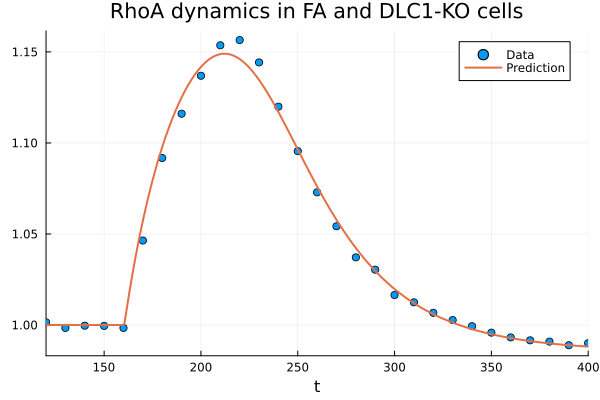

In [26]:
begin
	# Retrieve initial conditions from optimisation solution
	KO_predicted_u0 = [0;0;1]
	
    # Re-modify parameters as for optimisation
	KO_pred_p = KO_optim_results[1:4]
	
    # Solve the ODE problem with optimal parameters
	KO_pred_sol = solve(remake(Rho_KO_prob, p=KO_pred_p, u0=KO_predicted_u0, tspan=(120, 400)), saveat=0.5, dtmax = 0.05)
	scatter(timeframe[12:end], median_rhoa_FA_KO[12:end], label = "Data", lw=2, title = "RhoA dynamics in FA and DLC1-KO cells")
	plot!(KO_pred_sol, label = "Prediction", lw=2, idxs=3)
end

In [27]:
KO_optim_results.original

 * Status: success (objective increased between iterations)

 * Candidate solution
    Final objective value:     5.635605e-04

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 5.30e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   1327  (vs limit Inf)
    Iterations:    7
    f(x) calls:    65190
    ∇f(x) calls:   65190


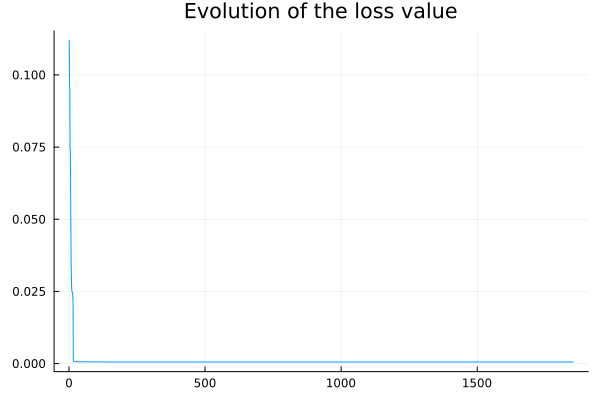

In [28]:
# Plot the loss value at each iteration
plot(KO_track_loss, title = "Evolution of the loss value", label = false)

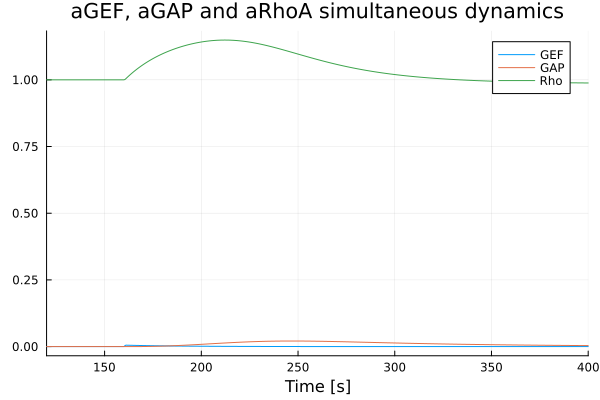

In [29]:
plot(KO_pred_sol, title = "aGEF, aGAP and aRhoA simultaneous dynamics", xlabel = "Time [s]")

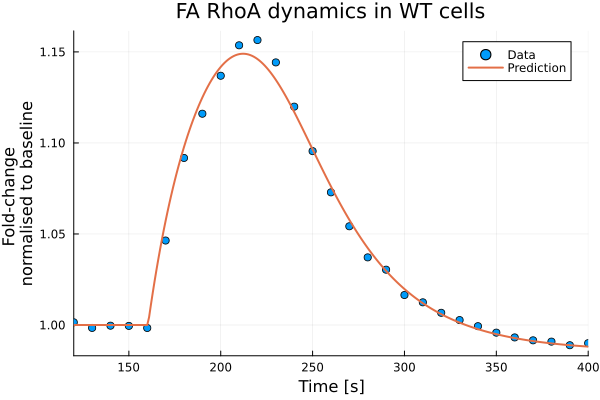

In [30]:
begin
	# Save best parameters
	saved_KO_parameters = [0.0129794, 0.0261144, 5.0, 1.3195]
	
    # Transform back ODE parameters to their symbolic expression
	saved_KO_param = [
		Rho_KO_model.Kon_GAP => saved_KO_parameters[get_idxparam(Rho_KO_model.Kon_GAP, Rho_KO_prob)],
		Rho_KO_model.Koff_GAP => saved_KO_parameters[get_idxparam(Rho_KO_model.Koff_GAP, Rho_KO_prob)],
		Rho_KO_model.Kon_Rho => saved_KO_parameters[get_idxparam(Rho_KO_model.Kon_Rho, Rho_KO_prob)],
		Rho_KO_model.Koff_Rho => saved_KO_parameters[get_idxparam(Rho_KO_model.Koff_Rho, Rho_KO_prob)]]
	
	saved_KO_u0 = [0;0;1]
	
    # Solve the ODE with the best parameters and plot
	saved_KO_pred_sol = solve(remake(Rho_KO_prob, p=saved_KO_param, u0 = saved_KO_u0, tspan=(120, 400)), saveat=1, dtmax=0.05) 
	scatter(timeframe[12:end], median_rhoa_FA_KO[12:end], label = "Data", lw=2, title = "FA RhoA dynamics in WT cells")
	plot!(saved_KO_pred_sol, label = "Prediction", lw=2, idxs=3, ylabel = "Fold-change \nnormalised to baseline", xlabel = "Time [s]")
end

In [31]:
saved_KO_param

4-element Vector{Pair{Num, Float64}}:
  Kon_GAP => 0.0261144
 Koff_GAP => 0.0129794
  Kon_Rho => 1.3195
 Koff_Rho => 5.0


### Comparison between DLC1-KO and WT data fitting



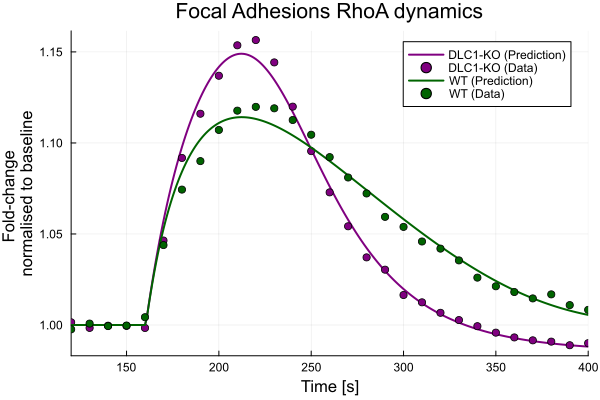

In [30]:
begin
	plot(saved_KO_pred_sol, lw=2, idxs=3, linecolor="#800080", label = "DLC1-KO (Prediction)", fontfamily="Arial")
	scatter!(timeframe[12:end], median_rhoa_FA_KO[12:end], label = "DLC1-KO (Data)", lw=2, title = "Focal Adhesions RhoA dynamics", markercolor="#800080")
	plot!(saved_pred_sol, lw=2, idxs=3, linecolor="#006400",label = "WT (Prediction)")
	scatter!(timeframe[12:end], median_rhoa_FA[12:end], label = "WT (Data)", markercolor="#006400")
	xlabel!("Time [s]")
	ylabel!("Fold-change \nnormalised to baseline")
	#savefig("../Plots/FA_plot_linear.svg")
end

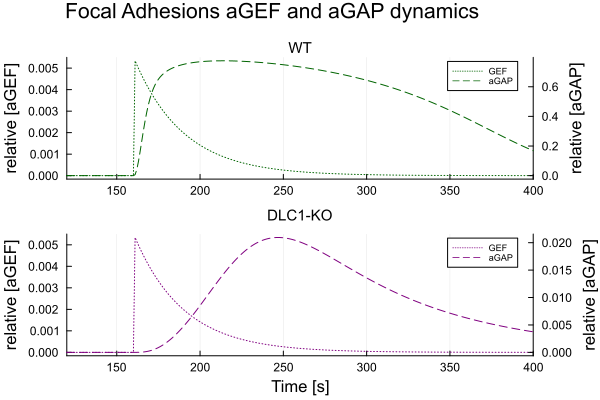

In [31]:
begin
	gef_plot = plot(saved_pred_sol, title = "", xlabel = "", idxs=1, linecolor="#006400", linestyle=:dot, legend_font_pointsize=6, ylabel="relative [aGEF]", legend=:best, fontfamily="Arial")
	plot!(timeframe[12:end], NaN.*timeframe[12:end], label = "aGAP", linestyle=:dash, linecolor="#006400")
	plot!(twinx(), saved_pred_sol, title = "\nWT", legend=false, xlabel = "", idxs=2, linecolor="#006400", linestyle=:dash, titlefontsize=10, ylabel="relative [aGAP]")
	gef_plot_KO = plot(saved_KO_pred_sol, title = "DLC1-KO", xlabel = "Time [s]", idxs=1, linecolor="#800080", linestyle=:dot, titlefontsize=10, legend_font_pointsize=6, ylabel="relative [aGEF]", fontfamily="Arial")
	plot!(timeframe[12:end], NaN .* timeframe[12:end], label = "aGAP", linestyle=:dash, linecolor="#800080")
	plot!(twinx(), saved_KO_pred_sol, title = "", idxs=2, linecolor="#800080", linestyle=:dash, xlabel = "", legend=false, ylabel="relative [aGAP]")
	plot(gef_plot, gef_plot_KO, layout=(2, 1), plot_title="Focal Adhesions aGEF and aGAP dynamics", plot_titlelocation=:left, plot_titlefontsize=14, )
	#savefig("../Plots/FA_all_plot_sharex_linear.svg")
end
